# Quant Finance - Clase 9 - PnL Attribution

### Importo los modulos

In [1]:
import sys
sys.path.append('..')
#Para poder leer los modulos dentro del directorio 
from library.stock import Stock
from library.options import StockOption
from library.market_data import MarketData
from library.curves import FlatZeroCurve
from library.volatility_surfaces import FlatVolatilitySurface
from library.bspricer import BlackScholesFormulaPricer
from library.mcpricer import SimpleMonteCarloPricer
from library.bsmodel import BlackScholesModel
from library.year_fractions import Actual360
from library.calendar import BusinessCalendar
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
stock_data = pd.read_pickle("./stock.pkl")
option_data = pd.read_pickle("./option.pkl")

In [3]:
stock_data

AAPL.OQ,HIGH,CLOSE,LOW,OPEN,COUNT,VOLUME
Date,,,,,,
2020-07-01,367.36,364.11,363.91,365.01,92072.0,6988790.0
2020-07-02,370.46,364.11,363.77,367.88,88893.0,7383006.0
2020-07-06,375.77,373.85,369.87,369.95,97020.0,8166626.0
2020-07-07,378.60,372.69,372.23,375.54,87691.0,7127551.0
2020-07-08,381.47,381.37,376.42,376.92,91659.0,7538375.0
2020-07-09,385.27,382.73,378.70,385.00,112073.0,7596239.0
2020-07-10,383.88,383.68,378.85,382.03,85262.0,6229963.0
2020-07-13,399.82,381.91,381.04,389.06,160361.0,11564198.0
2020-07-14,389.00,388.23,375.53,379.50,141689.0,10757195.0


In [4]:
option_data

AAPLJ162041000.U,HIGH,CLOSE,LOW,OPEN,VOLUME
Date,,,,,
2020-07-01,9.22,8.45,8.25,9.12,75.0
2020-07-02,9.60,7.45,7.45,9.60,158.0
2020-07-06,9.60,9.10,8.50,9.01,404.0
2020-07-07,10.82,10.03,9.30,9.30,152.0
2020-07-08,12.45,12.45,10.50,10.50,176.0
2020-07-09,14.11,13.35,12.85,13.79,180.0
2020-07-10,14.05,14.02,12.99,14.05,19.0
2020-07-13,22.96,15.83,15.83,17.50,917.0
2020-07-14,18.00,18.00,13.25,14.60,239.0


In [5]:
business_days = [date.date() for date in option_data.index]
business_days

[datetime.date(2020, 7, 1),
 datetime.date(2020, 7, 2),
 datetime.date(2020, 7, 6),
 datetime.date(2020, 7, 7),
 datetime.date(2020, 7, 8),
 datetime.date(2020, 7, 9),
 datetime.date(2020, 7, 10),
 datetime.date(2020, 7, 13),
 datetime.date(2020, 7, 14),
 datetime.date(2020, 7, 15),
 datetime.date(2020, 7, 16),
 datetime.date(2020, 7, 17),
 datetime.date(2020, 7, 20),
 datetime.date(2020, 7, 21),
 datetime.date(2020, 7, 22),
 datetime.date(2020, 7, 23),
 datetime.date(2020, 7, 24),
 datetime.date(2020, 7, 27),
 datetime.date(2020, 7, 28),
 datetime.date(2020, 7, 29),
 datetime.date(2020, 7, 30),
 datetime.date(2020, 7, 31)]

In [6]:
PnL = pd.DataFrame(index = business_days[1:], columns = ['PnL', 'PnLExplained', 'Delta PnL', 'Theta PnL', 'PnLUnexplained'])

for i in range(len(business_days)-1):
    today = business_days[i+1]
    prev = business_days[i]
    
    PnL.loc[today]['PnL'] = option_data.loc[today]['CLOSE'] - option_data.loc[prev]['CLOSE']
PnL

,PnL,PnLExplained,Delta PnL,Theta PnL,PnLUnexplained
2020-07-02,-1,NaN,NaN,NaN,NaN
2020-07-06,1.65,NaN,NaN,NaN,NaN
2020-07-07,0.93,NaN,NaN,NaN,NaN
2020-07-08,2.42,NaN,NaN,NaN,NaN
2020-07-09,0.9,NaN,NaN,NaN,NaN
2020-07-10,0.67,NaN,NaN,NaN,NaN
2020-07-13,1.81,NaN,NaN,NaN,NaN
2020-07-14,2.17,NaN,NaN,NaN,NaN
2020-07-15,1.24,NaN,NaN,NaN,NaN
2020-07-16,-1.94,NaN,NaN,NaN,NaN


In [7]:
stock = Stock( name = 'aapl' )
zero_curve = FlatZeroCurve( name = 'zero_curve', year_fraction = Actual360 )
vol_surface = FlatVolatilitySurface( name = 'aapl_vol' )

maturity = datetime.date(2020,10,16)
option_type = 'call'
option = StockOption(   underlier_name = 'aapl', 
                        strike = 410, 
                        maturity = maturity, 
                        payoff_name = option_type
                    )

market_data = MarketData()
market_data.add_stock( stock )
market_data.add_volatility_surface( vol_surface )
market_data.add_zero_curve( zero_curve )

pricer = BlackScholesFormulaPricer( option = option, market_data = market_data ) 
pricer_parameters = {'underlier_vol': 'aapl_vol', 'zero_curve': 'zero_curve'}
pricer.initialize_pricer(pricer_parameters)

for i in range(len(business_days)-1):
    
    today = business_days[i+1]
    prev = business_days[i]
    
    stock.add_close_price( time = prev, price = stock_data.loc[prev]['CLOSE'] )
    vol_surface.add_close_volatility( time = prev, strike = None, maturity = None, volatility = 0.287 )
    zero_curve.add_close_zero_rate( time = prev, zero_rate = 0.025 )
    
    #base npv
    npv = pricer.npv(time = prev)   
    
    #delta
    shift = 0.1
    market_data.shift_stock(name = 'aapl', time = prev, shift = shift)
    shifted_npv = pricer.npv(time = prev)
    market_data.unshift()
    delta = (shifted_npv - npv) / shift
    PnL.loc[today]['Delta PnL'] = delta * (stock_data.loc[today]['CLOSE'] - stock_data.loc[prev]['CLOSE'])
    
    #theta
    shift = today - prev
    market_data.roll(shift)
    shifted_npv = pricer.npv(time = prev + shift)
    shifted_npv - npv 
    market_data.unroll()
    theta = shifted_npv - npv
    PnL.loc[today]['Theta PnL'] = theta
    
    #PnLExplain
    PnL.loc[today]['PnLExplained'] = PnL.loc[today]['Theta PnL'] + PnL.loc[today]['Delta PnL']
    
    #PnLUnexplained
    PnL.loc[today]['PnLUnexplained'] = PnL.loc[today]['PnL'] - PnL.loc[today]['PnLExplained']
    
    
PnL

,PnL,PnLExplained,Delta PnL,Theta PnL,PnLUnexplained
2020-07-02,-1,-0.0930797,0,-0.0930797,-0.90692
2020-07-06,1.65,2.18125,2.55506,-0.373818,-0.531246
2020-07-07,0.93,-0.47292,-0.365874,-0.107046,1.40292
2020-07-08,2.42,2.55823,2.66407,-0.105833,-0.138233
2020-07-09,0.9,0.373969,0.490777,-0.116808,0.526031
2020-07-10,0.67,0.231442,0.350188,-0.118746,0.438558
2020-07-13,1.81,-1.0236,-0.661567,-0.362035,2.8336
2020-07-14,2.17,2.14721,2.26675,-0.119531,0.0227861
2020-07-15,1.24,0.941058,1.06804,-0.126981,0.298942
2020-07-16,-1.94,-2.13708,-2.00694,-0.130138,0.197081


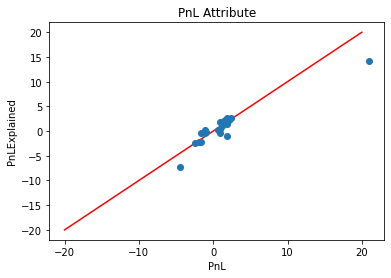

In [8]:
x = np.linspace(-20, 20, 1000)

plt.plot(x, x, 'r-')
plt.plot(PnL['PnL'].values, PnL['PnLExplained'].values, 'o')
plt.title('PnL Attribute')
plt.xlabel('PnL')
plt.ylabel('PnLExplained')

plt.show()

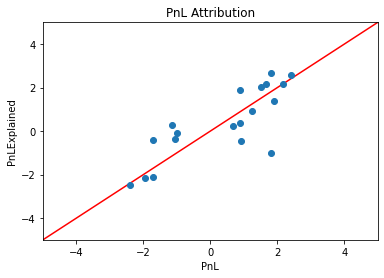

In [9]:
plt.plot(x, x, 'r-')
plt.plot(PnL['PnL'].values, PnL['PnLExplained'].values, 'o')
plt.title('PnL Attribution')
plt.xlabel('PnL')
plt.ylabel('PnLExplained')

plt.xlim(-5,5)
plt.ylim(-5,5)

plt.show()